<a href="https://colab.research.google.com/github/MuneebZafar00713/CS867-Assignment-3/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Drive mount and Dataset Unzip

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzip updated dataset from drive, with labelled test data
!mkdir dataset
%cd dataset
!unzip "/content/drive/MyDrive/updated-intel-image-classification.zip"
%cd ..

# VGG16 Model (using Transfer Learning)

In [1]:
from keras.applications.vgg16 import VGG16
from keras.models import Model
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout

In [2]:
# Load VGG16 model without classification layers
model = VGG16(include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 0s 0us/step


**Adding Flatten Dense and Dropout Layers to VGG16**

In [3]:
# Add new classification layers
flat1 = Flatten()(model.layers[-1].output) # flatten last layer
class1 = Dense(1024, activation='relu')(flat1) # add FC layer on previous layer
drop1 = Dropout(0.5)(class1)
class2 = Dense(104, activation='relu')(drop1) # add FC layer on previous layer
drop2 = Dropout(0.5)(class2)
output = Dense(6, activation='softmax')(drop2) # add softmax layer

# Model Summary

In [4]:
# Print model summary
model = Model(inputs=model.inputs, outputs=output)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Freeze First Few Layers

In [7]:
for layer in model.layers[:-10]:
  layer.trainable = False

for layer in model.layers:
  print(layer.name, "\tTrainable: ", layer.trainable)

input_1 	Trainable:  False
block1_conv1 	Trainable:  False
block1_conv2 	Trainable:  False
block1_pool 	Trainable:  False
block2_conv1 	Trainable:  False
block2_conv2 	Trainable:  False
block2_pool 	Trainable:  False
block3_conv1 	Trainable:  False
block3_conv2 	Trainable:  False
block3_conv3 	Trainable:  False
block3_pool 	Trainable:  False
block4_conv1 	Trainable:  False
block4_conv2 	Trainable:  False
block4_conv3 	Trainable:  False
block4_pool 	Trainable:  False
block5_conv1 	Trainable:  True
block5_conv2 	Trainable:  True
block5_conv3 	Trainable:  True
block5_pool 	Trainable:  True
flatten 	Trainable:  True
dense 	Trainable:  True
dropout 	Trainable:  True
dense_1 	Trainable:  True
dropout_1 	Trainable:  True
dense_2 	Trainable:  True


# Training Data Augmentation

In [8]:
import tensorflow as tf

# Training Data augmentation for better learning/classification
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=90,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
        'dataset/seg_train/seg_train/',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.


**Validation Data Generation**

In [9]:
# Validation Data Generation
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
        'dataset/seg_test/seg_test/',
        target_size=(150, 150),
        batch_size=32,
        class_mode='categorical')

Found 3000 images belonging to 6 classes.


# SGD Optimizer with Time-Based Decay

In [10]:
from keras.optimizers import SGD

epochs = 10
momentum = 0.9
learning_rate = 0.001
decay_rate = learning_rate / epochs

sgd = SGD(lr=learning_rate,
          momentum=momentum,
          decay=decay_rate,
          nesterov=False)

model.compile(loss='categorical_crossentropy', 
              optimizer=sgd,
              metrics=['accuracy'])

# Model Training (Model Fitting)

In [11]:
H = model.fit(train_generator,
              validation_data=validation_generator,
              epochs=epochs)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/image_data_generator.py:728: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/10
439/439 [==============================] - 96s 210ms/step - loss: 1.2970 - accuracy: 0.4740 - val_loss: 0.4702 - val_accuracy: 0.8287
Epoch 2/10
439/439 [==============================] - 91s 207ms/step - loss: 0.6150 - accuracy: 0.7829 - val_loss: 0.4493 - val_accuracy: 0.8357
Epoch 3/10
439/439 [==============================] - 90s 205ms/step - loss: 0.5370 - accuracy: 0.8157 - val_loss: 0.3547 - val_accuracy: 0.8650
Epoch 4/10
439/439 [==============================] - 90s 206ms/step - loss: 0.4745 - accuracy: 0.8404 - val_loss: 0.3791 - val_accuracy: 0.8637
Epoch 5/10
439/439 [==============================] - 90s 205ms/step - loss: 0.4518 - accuracy: 0.8459 - val_loss: 0.3391 - val_accuracy: 0.8793
Epoch 6/10
439/439 [==============================] - 90s 205ms/step - loss: 0.4397 - accuracy: 0.8446 - val_loss: 0.3504 - val_accuracy: 0.8747
Epoch 7/10
439/439 [==============================] - 90s 205ms/step - loss: 0.4181 - accuracy: 0.8517 - val_loss: 0.3677 - val_ac

# Trained Model Graph (Accuracy, Loss, Val Accuray, Val Loss)

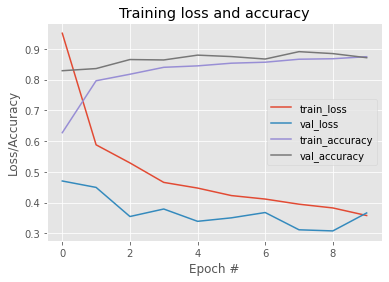

In [12]:
'''LEARNING CURVE'''
import numpy as np
import matplotlib.pyplot as plt
N = np.arange(0, epochs)
plt.style.use('ggplot')
plt.figure()
plt.plot(N, H.history['loss'], label='train_loss')
plt.plot(N, H.history['val_loss'], label='val_loss')
plt.plot(N, H.history['accuracy'], label='train_accuracy')
plt.plot(N, H.history['val_accuracy'], label='val_accuracy')
plt.title('Training loss and accuracy')
plt.xlabel('Epoch #')
plt.ylabel('Loss/Accuracy')
plt.legend()
plt.show()

**Save Model Weights**

In [13]:
# Save the model's trained weights
model.save_weights('vgg16_transfer_trained_wts.h5')

**Load Model Weights (If Required)**

In [14]:
# Load the model's trained weights (if required)
model.load_weights("vgg16_transfer_trained_wts.h5")

In [15]:
import os
import cv2
import numpy as np
from imutils import paths
from sklearn.preprocessing import LabelBinarizer
from tqdm import tqdm

**Function to Load (Test) Data from directory**

In [16]:
# A function to load data from a given directory
def load_data(data_dir):
  data = []
  labels = []
  class_dirs = os.listdir(data_dir)
  
  for direc in class_dirs:
    class_dir = os.path.join(data_dir, direc)
    for imagepath in tqdm(list(paths.list_images(class_dir))):
      image = cv2.imread(imagepath)
      image = cv2.resize(image, (150, 150))  # incase images not of same size
      data.append(image)
      labels.append(direc)
  # normalizing and converting to numpy array format
  data = np.array(data, dtype='float')/255.0
  labels = np.array(labels)
  return data, labels

**Load Test Data**

In [17]:
test_dir = "dataset/seg_pred/seg_pred/"

print('Loading test images:')
X_test, y_test = load_data(test_dir)

 21%|██        | 236/1128 [00:00<00:00, 2358.93it/s]

Loading test images:


100%|██████████| 1330/1330 [00:00<00:00, 2034.61it/s]


**Test Labels to One Hot Encoding**

In [18]:
lb = LabelBinarizer()
y_test = lb.fit_transform(y_test)

# Test Data Evaluation Results (Accuracy, Loss)

In [19]:
score = model.evaluate(X_test, y_test, batch_size=32)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])

229/229 [==============================] - 15s 67ms/step - loss: 0.3858 - accuracy: 0.8602
Test Loss:  0.385844349861145
Test Accuracy:  0.8601561188697815


# Confusion Matrix

In [20]:
'''CONFUSION MATRIX'''
# Making prediction
y_pred = model.predict(X_test)
y_true = np.argmax(y_test, axis=-1)

# Plotting the confusion matrix
from sklearn.metrics import confusion_matrix
confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
confusion_mtx

array([[1087,    3,    3,    2,    4,   45],
       [   5, 1143,    3,    4,    8,    3],
       [   0,   11, 1150,  115,   48,    6],
       [   3,   15,  277,  913,   85,    4],
       [  19,   10,  113,   57,  913,   16],
       [ 135,   15,    6,    2,    4, 1074]])

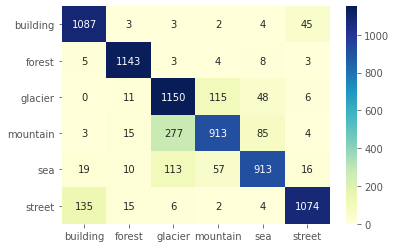

In [21]:
classes = ('building', 'forest', 'glacier', 'mountain', 'sea', 'street')

import seaborn as sns
sns.heatmap(confusion_mtx, xticklabels=classes, yticklabels=classes, annot=True, fmt='d', cmap="YlGnBu")

# Classification Report (Precision, Recall, F1-score, Support)

In [22]:
from sklearn.metrics import classification_report
predictions = model.predict(X_test, batch_size=32)
print(classification_report(y_test.argmax(axis=1), predictions.argmax(axis=1), target_names=classes))

              precision    recall  f1-score   support

    building       0.87      0.95      0.91      1144
      forest       0.95      0.98      0.97      1166
     glacier       0.74      0.86      0.80      1330
    mountain       0.84      0.70      0.76      1297
         sea       0.86      0.81      0.83      1128
      street       0.94      0.87      0.90      1236

    accuracy                           0.86      7301
   macro avg       0.87      0.86      0.86      7301
weighted avg       0.86      0.86      0.86      7301



# Test Data Visual Results

In [23]:
def one_hot_encoding(pred):
  ohe = [0] * len(pred) # Equal to categories (i.e. 6)
  index = 0
  for i in range(len(pred)):
    if (pred[i] > pred[index]):
      index = i
  ohe[index] = 1
  return ohe

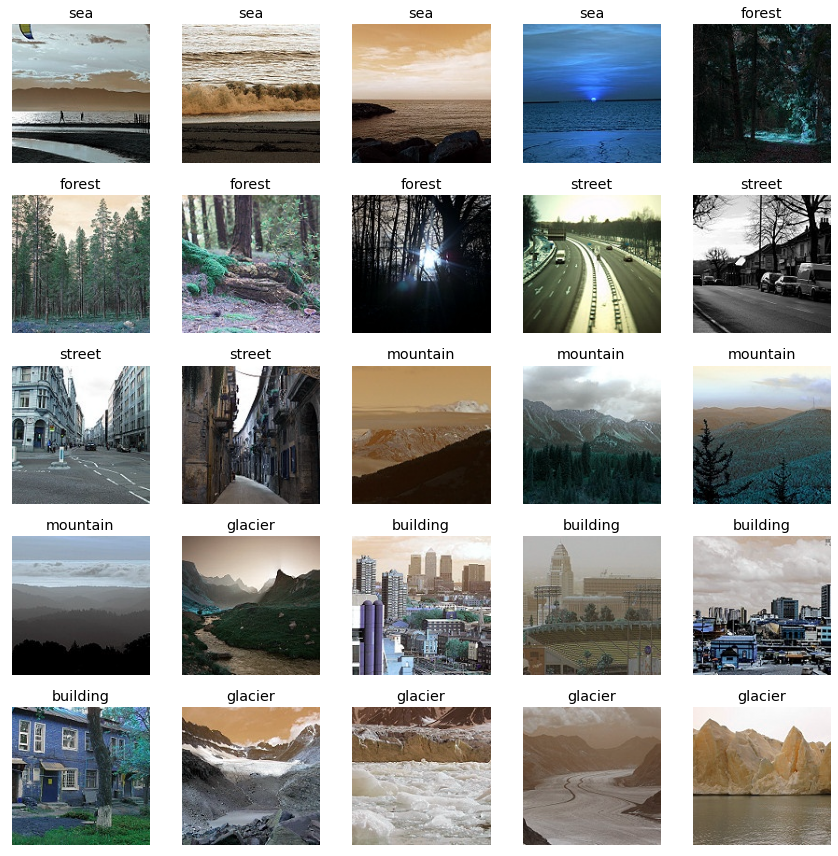

In [24]:
# visualize some images
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

classes = ('building', 'forest', 'glacier', 'mountain', 'sea', 'street')

fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True, figsize=(12,12))
num=0
for i in range(5):
    for j in range(5):
        img = X_test[num]
        ax[i][j].imshow(img)
        ohe = one_hot_encoding(y_pred[num])
        ax[i][j].set_title(classes[ohe.index(1)])
        num += 295
        
ax[0][0].set_yticks([])
ax[0][0].set_xticks([])
plt.tight_layout()
plt.show()